# Projeto Final
### Mineração de Dados
  
Base de Dados: Employee Analysis | Attrition Report  
https://www.kaggle.com/datasets/whenamancodes/hr-employee-attrition  
  
Base de dados fictício criado pela IBM. 
  
Fatores que levam ao desgaste (Attrition) dos funcionários.

### Importação das biliotecas e dados

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import (recall_score,
                             accuracy_score,
                             precision_score,
                             f1_score)
from sklearn.metrics import classification_report

from venny4py.venny4py import *
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv("../Atividades/dados/HREmployeeAttrition.csv")

### Análises iniciais - EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [4]:
print(df.isnull().sum())

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

In [5]:
df.shape

(1470, 35)

Portanto, nenhum dado faltante. 

In [6]:
# Definição do tipo de coluna: 
# Se tiver apenas um valor ou tiver um valor diferente por linha, é descartável
# Se tiver menos de 10 valores, é categórica
# Em todos os outros casos, é numérica / contínua

catFeatures = []
dropFeatures = []
contFeatures = []
for col in df.columns:
    if ( (df[col].nunique() == 1) or (df[col].nunique() == 1470) ):
        tipo = 'drop'
        dropFeatures.append(col)
    elif df[col].nunique() < 10:
        tipo = 'catg'
        catFeatures.append(col)
    else:
        tipo = 'cont'
        contFeatures.append(col)
    print(f"{df[col].nunique():4d} | {tipo} | {df[col].dtype} | {col} ")
    

  43 | cont | int64 | Age 
   2 | catg | object | Attrition 
   3 | catg | object | BusinessTravel 
 886 | cont | int64 | DailyRate 
   3 | catg | object | Department 
  29 | cont | int64 | DistanceFromHome 
   5 | catg | int64 | Education 
   6 | catg | object | EducationField 
   1 | drop | int64 | EmployeeCount 
1470 | drop | int64 | EmployeeNumber 
   4 | catg | int64 | EnvironmentSatisfaction 
   2 | catg | object | Gender 
  71 | cont | int64 | HourlyRate 
   4 | catg | int64 | JobInvolvement 
   5 | catg | int64 | JobLevel 
   9 | catg | object | JobRole 
   4 | catg | int64 | JobSatisfaction 
   3 | catg | object | MaritalStatus 
1349 | cont | int64 | MonthlyIncome 
1427 | cont | int64 | MonthlyRate 
  10 | cont | int64 | NumCompaniesWorked 
   1 | drop | object | Over18 
   2 | catg | object | OverTime 
  15 | cont | int64 | PercentSalaryHike 
   2 | catg | int64 | PerformanceRating 
   4 | catg | int64 | RelationshipSatisfaction 
   1 | drop | int64 | StandardHours 
   4 | ca

In [7]:
df.drop(columns=dropFeatures, inplace=True)

#### Correlação entre variáveis numéricas

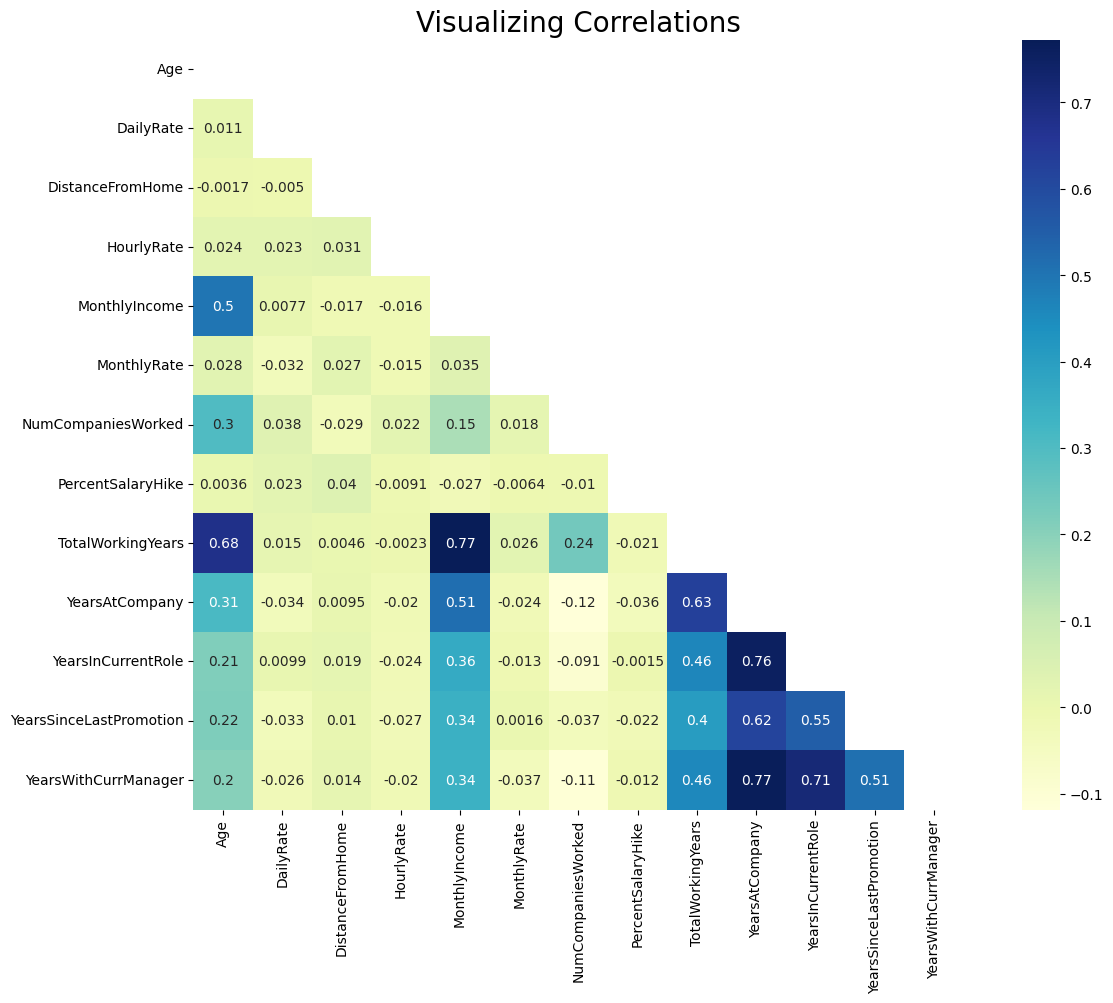

In [8]:
mask = np.triu(np.ones_like(df[contFeatures].corr()))
plt.figure(figsize = (15, 10))
sns.heatmap(df[contFeatures].corr(), cmap = 'YlGnBu', square = True, annot = True, mask = mask)
plt.title("Visualizing Correlations", size = 20)
plt.show()

Não é seguro eliminar nenhuma variável numérica a princípio, já que a maior correlação encontrada foi de 0.77 

### Transformando as features

#### Utilizando Standard Scaler

In [9]:
df_raw = df.copy()
scaler = StandardScaler()
normalizacao = scaler.fit(df[contFeatures])
df[contFeatures] = normalizacao.transform(df[contFeatures])

#### Variáveis categóricas
Como primeira abordagem, usarei o LabelEncoder, do Scikit-Learn.   
Em paralelo, usarei o one-hot encoding para futuramente verificar qual tem melhor desempenho. 

In [10]:
dfLabelEncoder = df.copy()
labelencoder = LabelEncoder()
dfLabelEncoder[catFeatures] = dfLabelEncoder[catFeatures].apply(labelencoder.fit_transform)
dfLabelEncoder.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,0.446350,1,2,0.742527,2,-1.010909,1,1,1,0,...,0,0,0,-0.421642,0,0,-0.164613,-0.063296,-0.679146,0.245834
1,1.322365,0,1,-1.297775,1,-0.147150,0,1,2,1,...,1,3,1,-0.164511,3,2,0.488508,0.764998,-0.368715,0.806541
2,0.008343,1,2,1.414363,1,-0.887515,1,4,3,1,...,0,1,0,-0.550208,3,2,-1.144294,-1.167687,-0.679146,-1.155935
3,-0.429664,0,1,1.461466,1,-0.764121,3,1,3,0,...,0,2,0,-0.421642,3,2,0.161947,0.764998,0.252146,-1.155935
4,-1.086676,0,2,-0.524295,1,-0.887515,0,3,0,1,...,0,3,1,-0.678774,3,2,-0.817734,-0.615492,-0.058285,-0.595227


In [11]:
dfOneHot = df.copy()
for col in catFeatures:
    if col == 'Attrition':
        labelencoder = LabelEncoder()
        dfOneHot[['Attrition']] = dfOneHot[['Attrition']].apply(labelencoder.fit_transform)
    else:
        dfOneHot = pd.get_dummies(data=dfOneHot, columns=[col])

### Desenvolvendo os pipelines

Considerei os classificadores KNN, Decision Tree e Random Forest, e como técnicas de seleção de atributos, Mutual Information, Anova e SmartCorrelatedGroups (a exemplo do que foi realizado na atividade 2)

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from feature_engine.selection import SmartCorrelatedSelection

In [13]:
XLE = dfLabelEncoder.drop(['Attrition'], axis=1)
yLE = dfLabelEncoder['Attrition']
XOH = dfOneHot.drop(['Attrition'], axis=1)
yOH = dfOneHot['Attrition']


In [14]:
X_trainLE, X_testLE, y_trainLE, y_testLE = train_test_split(XLE, yLE, test_size=0.3)
X_trainOH, X_testOH, y_trainOH, y_testOH = train_test_split(XOH, yOH, test_size=0.3)

#### Configuração das técnicas que serão utilizadas

In [27]:
treeLE = DecisionTreeClassifier()
treeLE.fit(X_trainLE, y_trainLE)
treeLE_pred = treeLE.predict(X_testLE)

knnLE = KNeighborsClassifier()
knnLE.fit(X_trainLE, y_trainLE)
knnLE_pred = knnLE.predict(X_testLE)

forestLE = RandomForestClassifier(n_estimators = 100)
forestLE.fit(X_trainLE, y_trainLE)
forestLE_pred = forestLE.predict(X_testLE)

treeOH = DecisionTreeClassifier()
treeOH.fit(X_trainOH, y_trainOH)
treeOH_pred = treeOH.predict(X_testOH)

knnOH = KNeighborsClassifier()
knnOH.fit(X_trainOH, y_trainOH)
knnOH_pred = knnOH.predict(X_testOH)

forestOH = RandomForestClassifier(n_estimators = 100)
forestOH.fit(X_trainOH, y_trainOH)
forestOH_pred = forestOH.predict(X_testOH)


mi = SelectKBest(mutual_info_classif, k=20)

anova = SelectKBest(f_classif, k=20)

smartC = SmartCorrelatedSelection(
    method="pearson",
    threshold=0.8,
    selection_method="variance",
    estimator=None
)

#### Criando os pipelines

##### Label Encoder

In [28]:
ppl1LE = Pipeline([('mi_s', mi), ('knn_c', knnLE)])
ppl1LE.fit(X_trainLE, y_trainLE)
ppl1LE_pred = ppl1LE.predict(X_testLE)

ppl2LE = Pipeline([('mi_s', mi), ('dt_c', treeLE)])
ppl2LE.fit(X_trainLE, y_trainLE)
ppl2LE_pred = ppl2LE.predict(X_testLE)

ppl3LE = Pipeline([('mi_s', mi), ('rf_c', forestLE)])
ppl3LE.fit(X_trainLE, y_trainLE)
ppl3LE_pred = ppl3LE.predict(X_testLE)

ppl4LE = Pipeline([('anova_s', anova), ('knn_c', knnLE)])
ppl4LE.fit(X_trainLE, y_trainLE)
ppl4LE_pred = ppl4LE.predict(X_testLE)

ppl5LE = Pipeline([('anova_s', anova), ('dt_c', treeLE)])
ppl5LE.fit(X_trainLE, y_trainLE)
ppl5LE_pred = ppl5LE.predict(X_testLE)

ppl6LE = Pipeline([('anova_s', anova), ('rf_c', forestLE)])
ppl6LE.fit(X_trainLE, y_trainLE)
ppl6LE_pred = ppl6LE.predict(X_testLE)

ppl7LE = Pipeline([('smartc_s', smartC), ('knn_c', knnLE)])
ppl7LE.fit(X_trainLE, y_trainLE)
ppl7LE_pred = ppl7LE.predict(X_testLE)

ppl8LE = Pipeline([('smartc_s', smartC), ('dt_c', treeLE)])
ppl8LE.fit(X_trainLE, y_trainLE)
ppl8LE_pred = ppl8LE.predict(X_testLE)

ppl9LE = Pipeline([('smartc_s', smartC), ('rf_c', forestLE)])
ppl9LE.fit(X_trainLE, y_trainLE)
ppl9LE_pred = ppl9LE.predict(X_testLE)

##### One Hot Encoder

In [29]:
ppl1OH = Pipeline([('mi_s', mi), ('knn_c', knnOH)])
ppl1OH.fit(X_trainOH, y_trainOH)
ppl1OH_pred = ppl1OH.predict(X_testOH)

ppl2OH = Pipeline([('mi_s', mi), ('dt_c', treeOH)])
ppl2OH.fit(X_trainOH, y_trainOH)
ppl2OH_pred = ppl2OH.predict(X_testOH)

ppl3OH = Pipeline([('mi_s', mi), ('rf_c', forestOH)])
ppl3OH.fit(X_trainOH, y_trainOH)
ppl3OH_pred = ppl3OH.predict(X_testOH)

ppl4OH = Pipeline([('anova_s', anova), ('knn_c', knnOH)])
ppl4OH.fit(X_trainOH, y_trainOH)
ppl4OH_pred = ppl4OH.predict(X_testOH)

ppl5OH = Pipeline([('anova_s', anova), ('dt_c', treeOH)])
ppl5OH.fit(X_trainOH, y_trainOH)
ppl5OH_pred = ppl5OH.predict(X_testOH)

ppl6OH = Pipeline([('anova_s', anova), ('rf_c', forestOH)])
ppl6OH.fit(X_trainOH, y_trainOH)
ppl6OH_pred = ppl6OH.predict(X_testOH)

ppl7OH = Pipeline([('smartc_s', smartC), ('knn_c', knnOH)])
ppl7OH.fit(X_trainOH, y_trainOH)
ppl7OH_pred = ppl7OH.predict(X_testOH)

ppl8OH = Pipeline([('smartc_s', smartC), ('dt_c', treeOH)])
ppl8OH.fit(X_trainOH, y_trainOH)
ppl8OH_pred = ppl8OH.predict(X_testOH)

ppl9OH = Pipeline([('smartc_s', smartC), ('rf_c', forestOH)])
ppl9OH.fit(X_trainOH, y_trainOH)
ppl9OH_pred = ppl9OH.predict(X_testOH)

### Avaliando as métricas

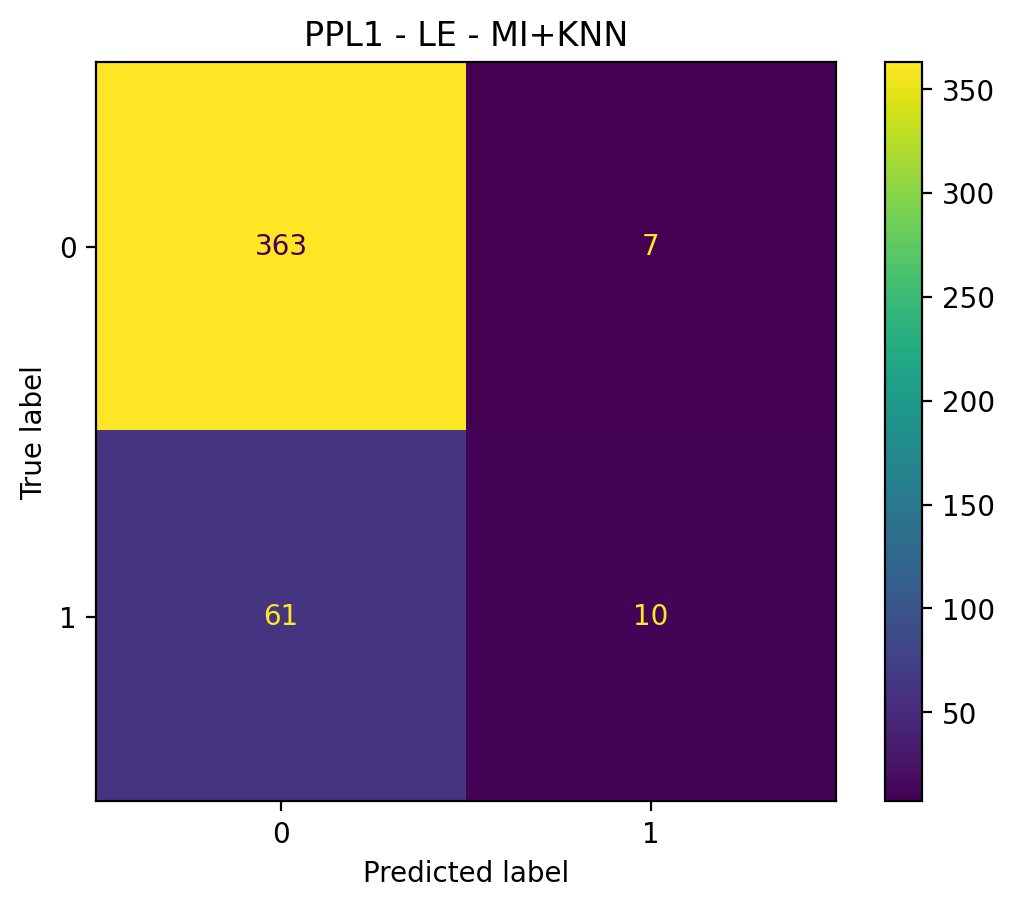

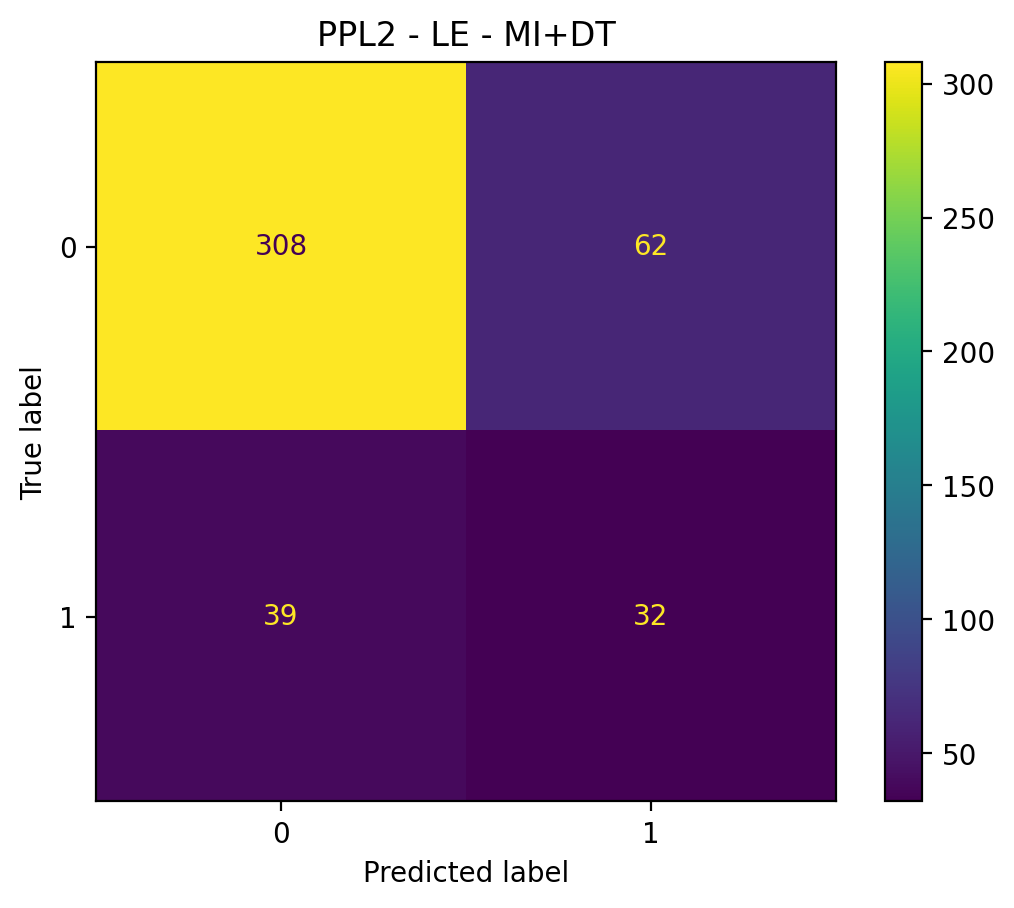

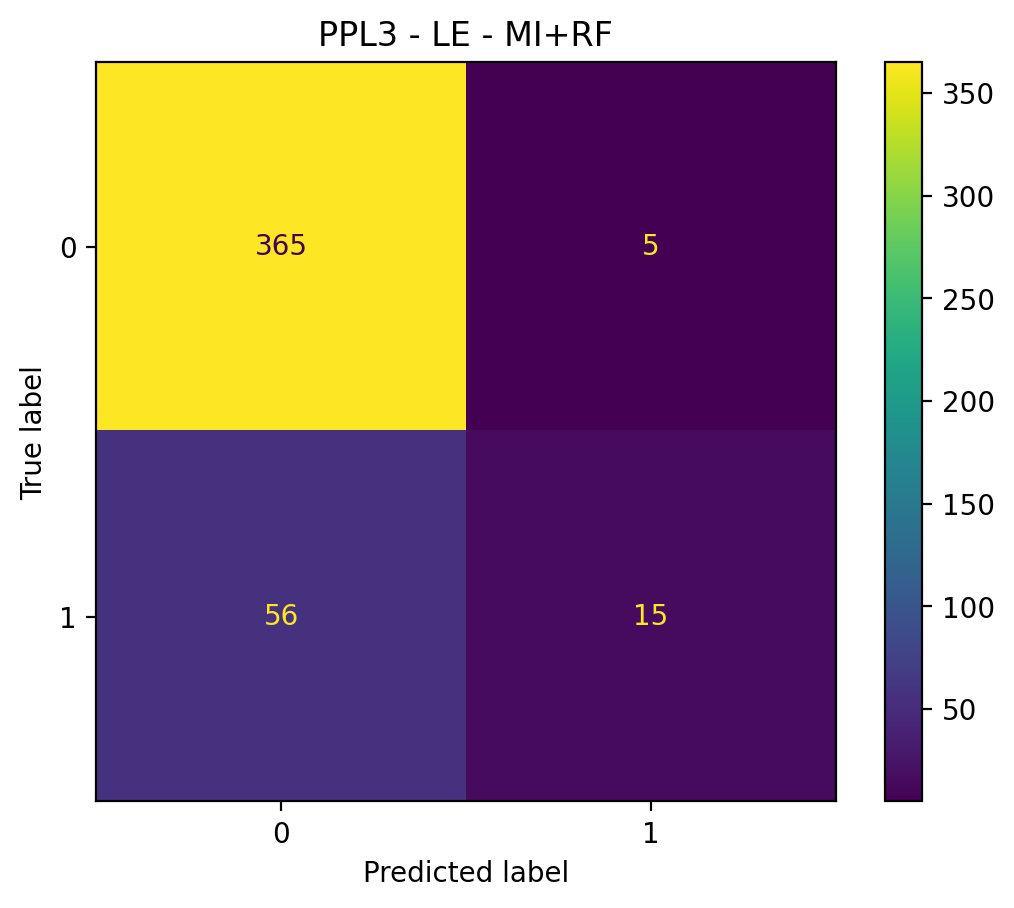

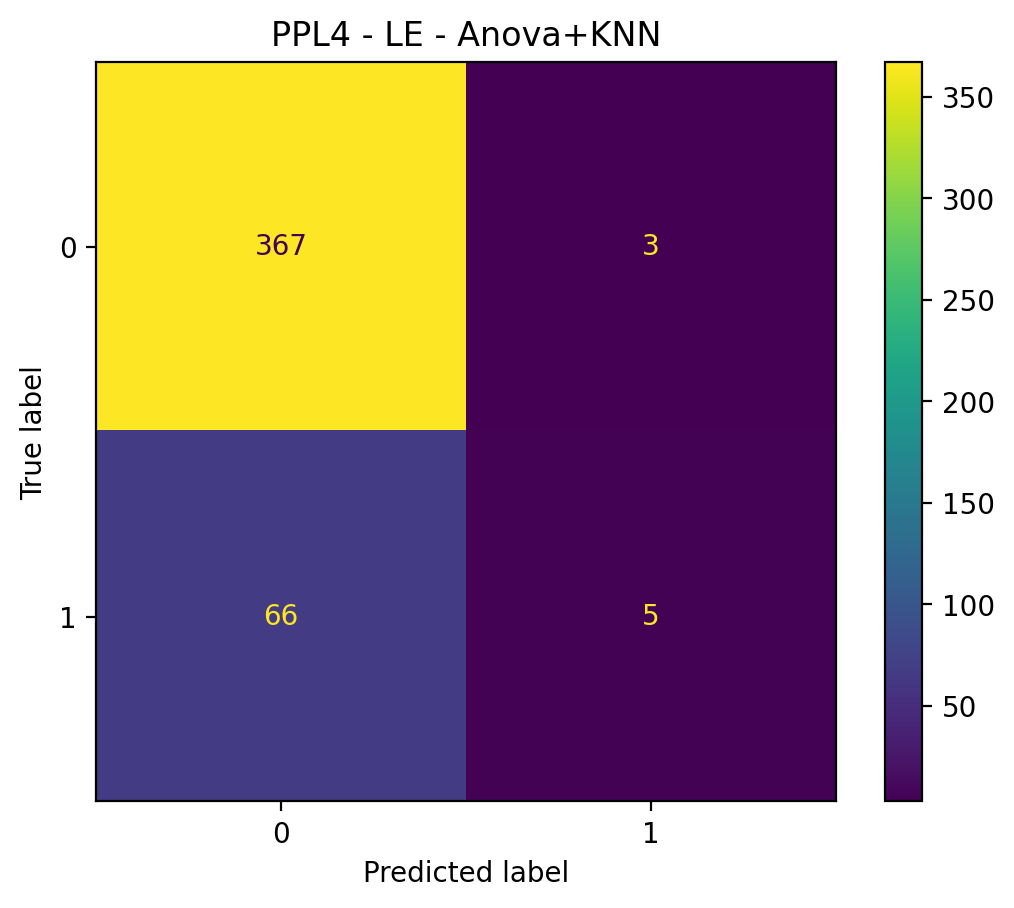

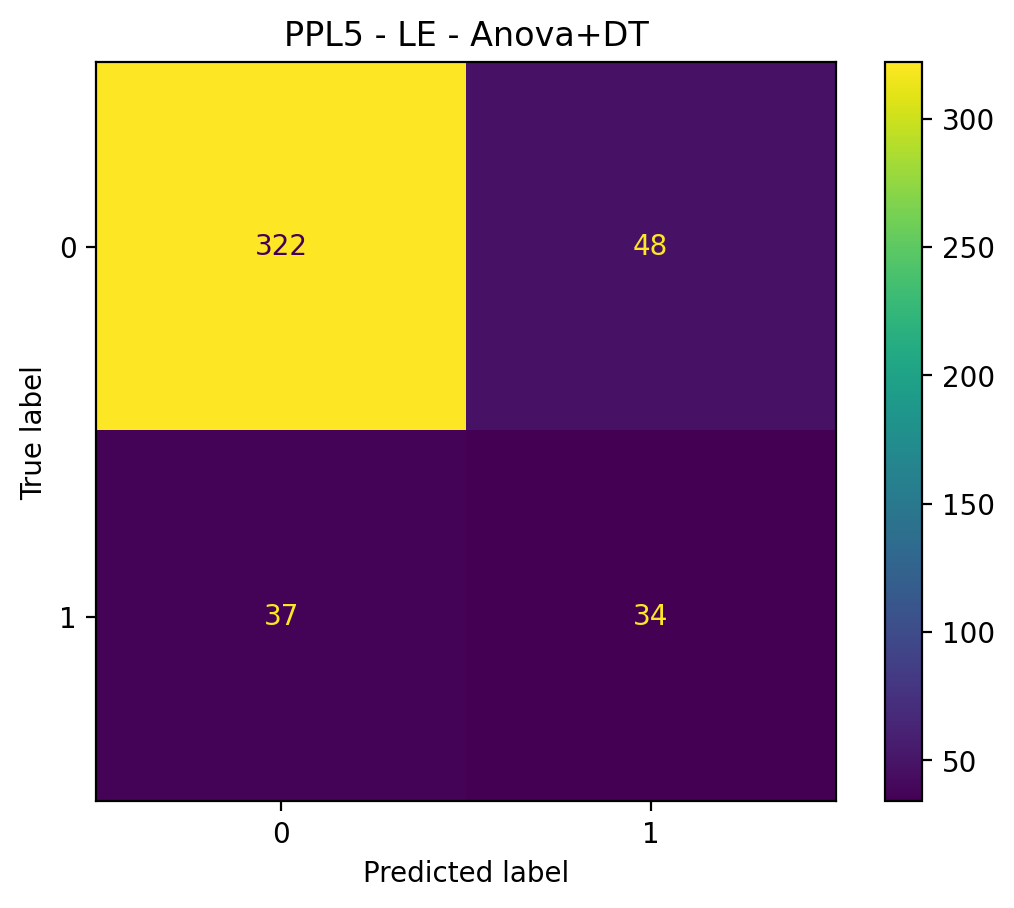

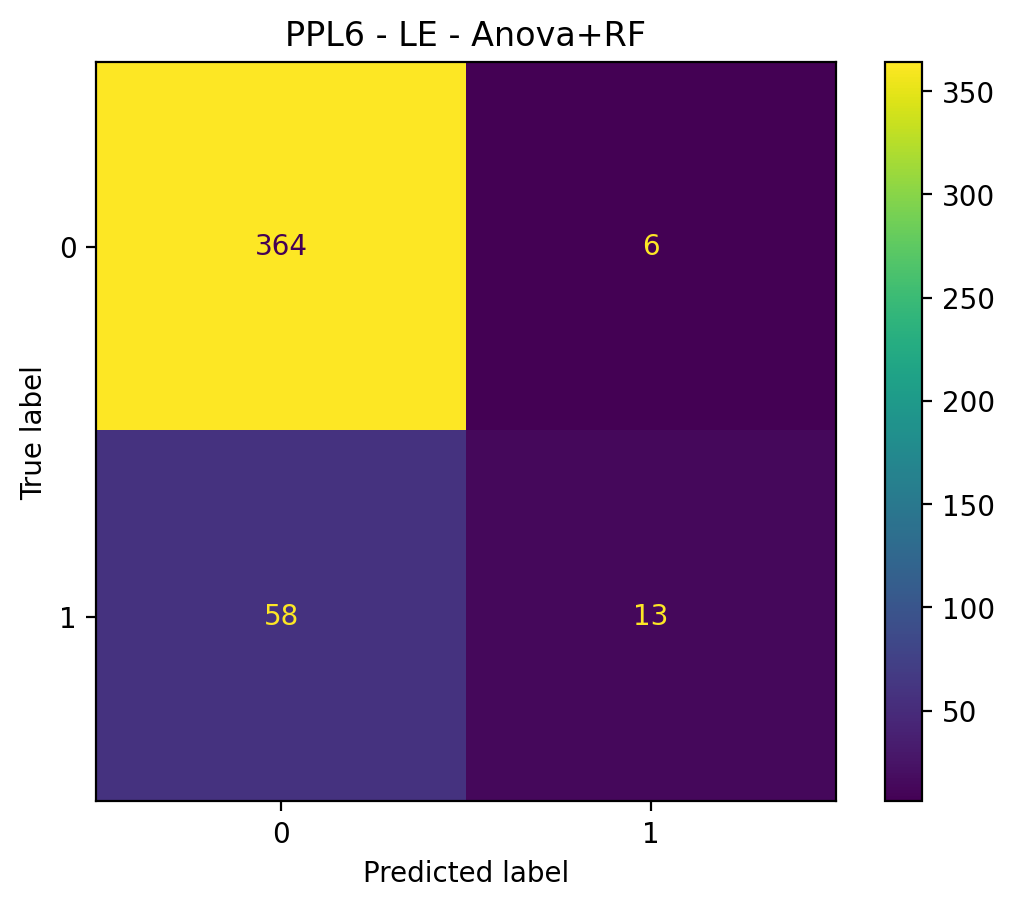

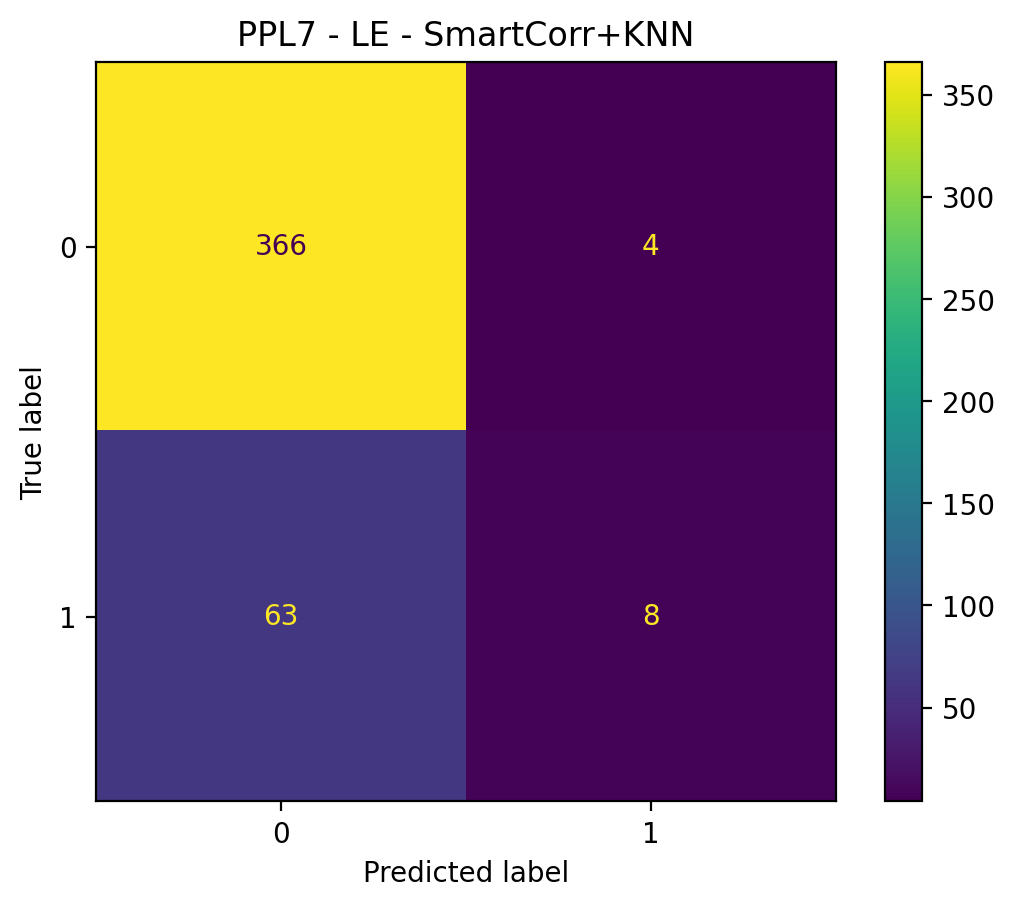

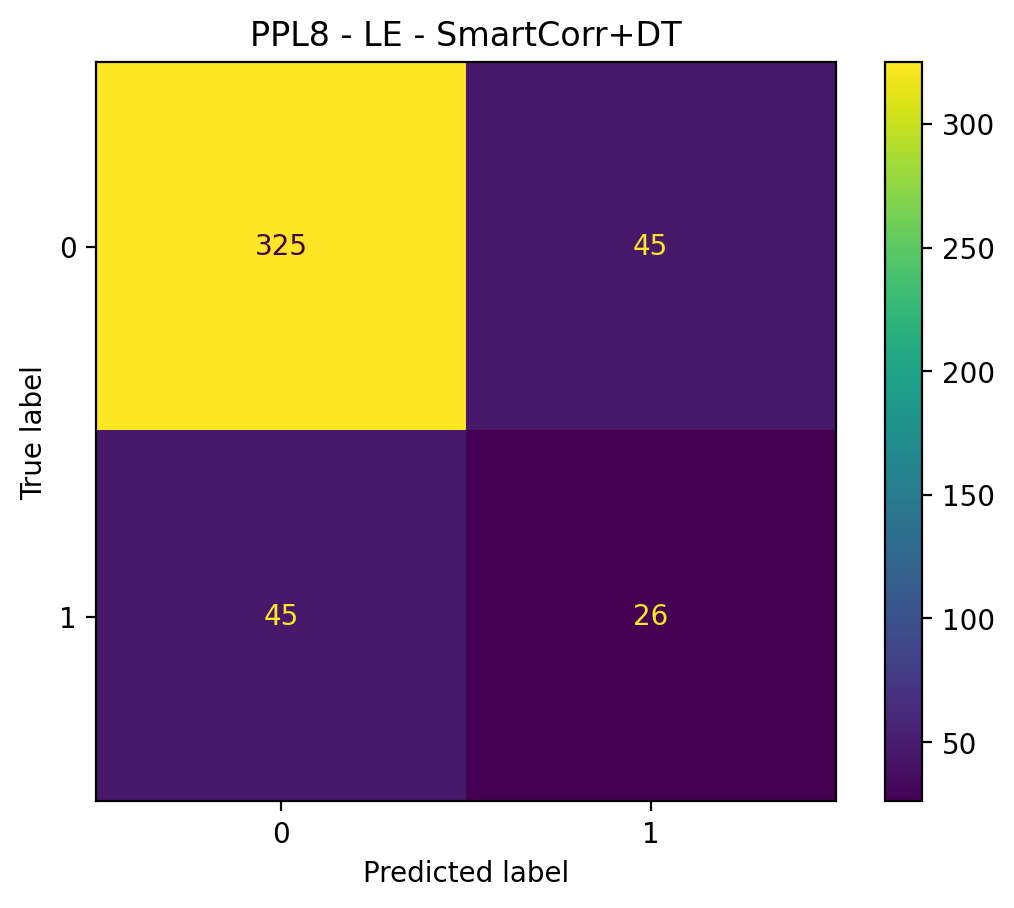

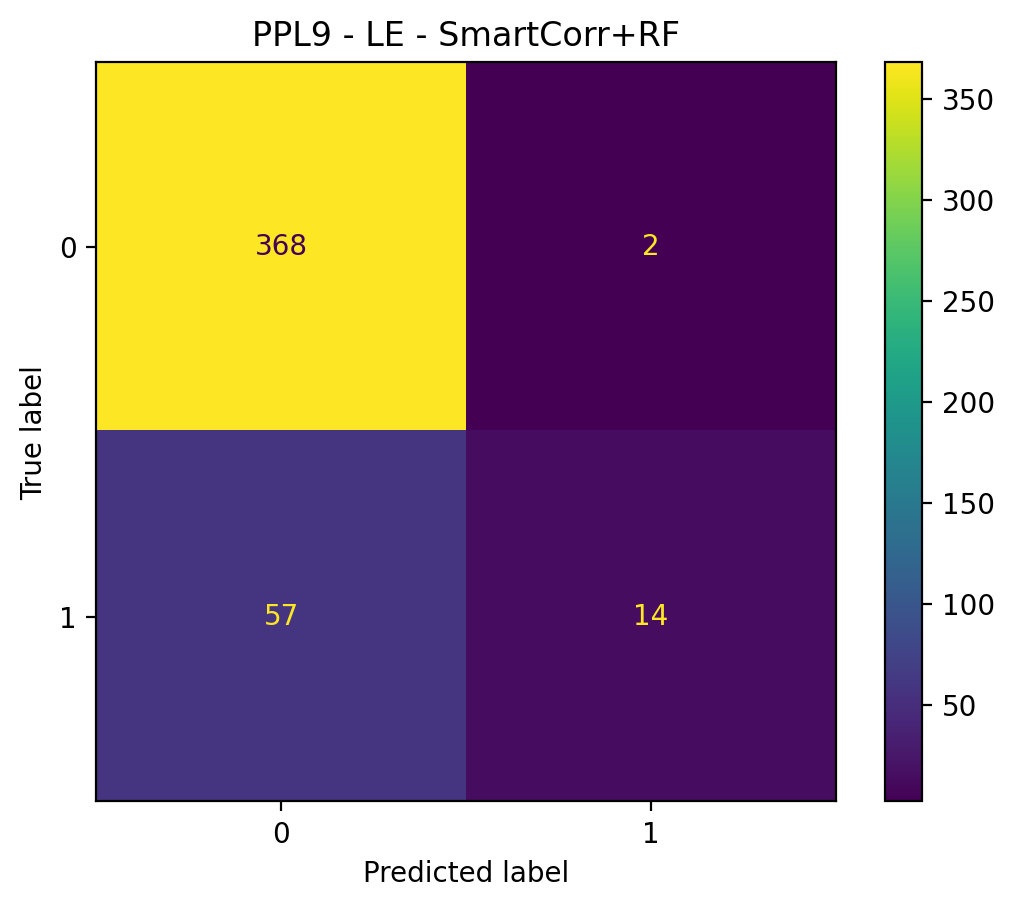

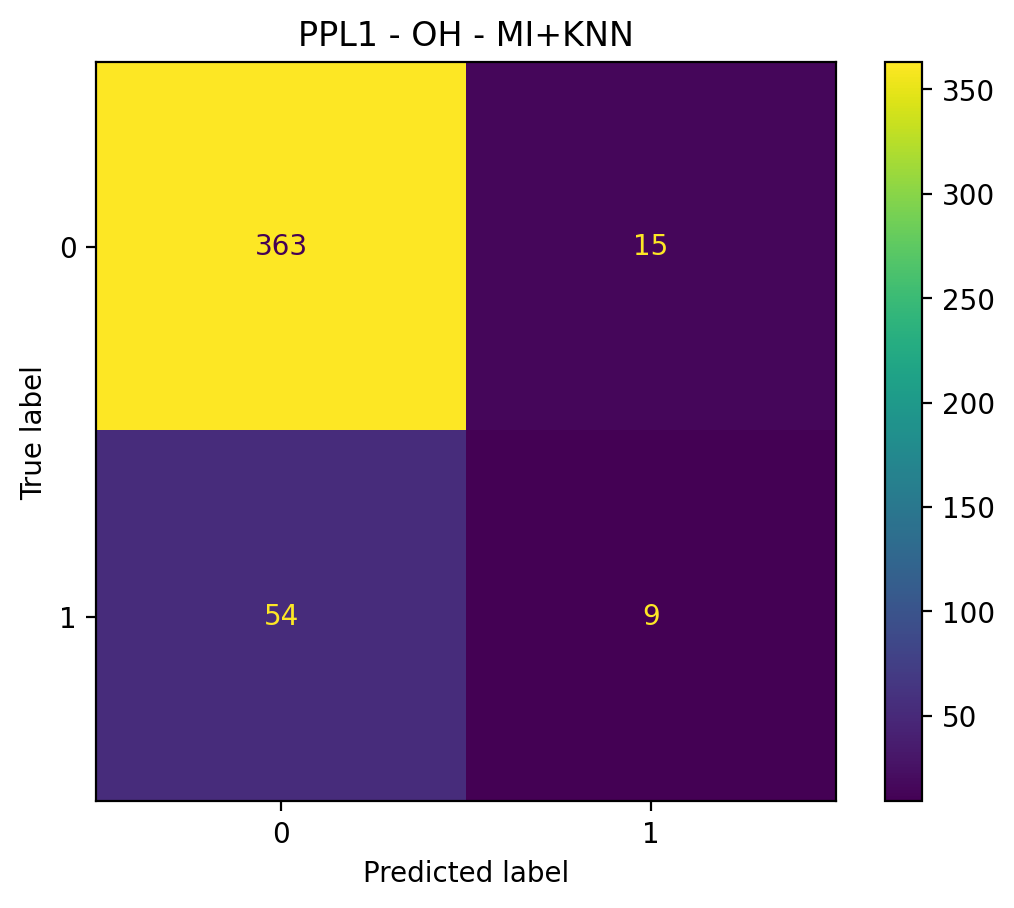

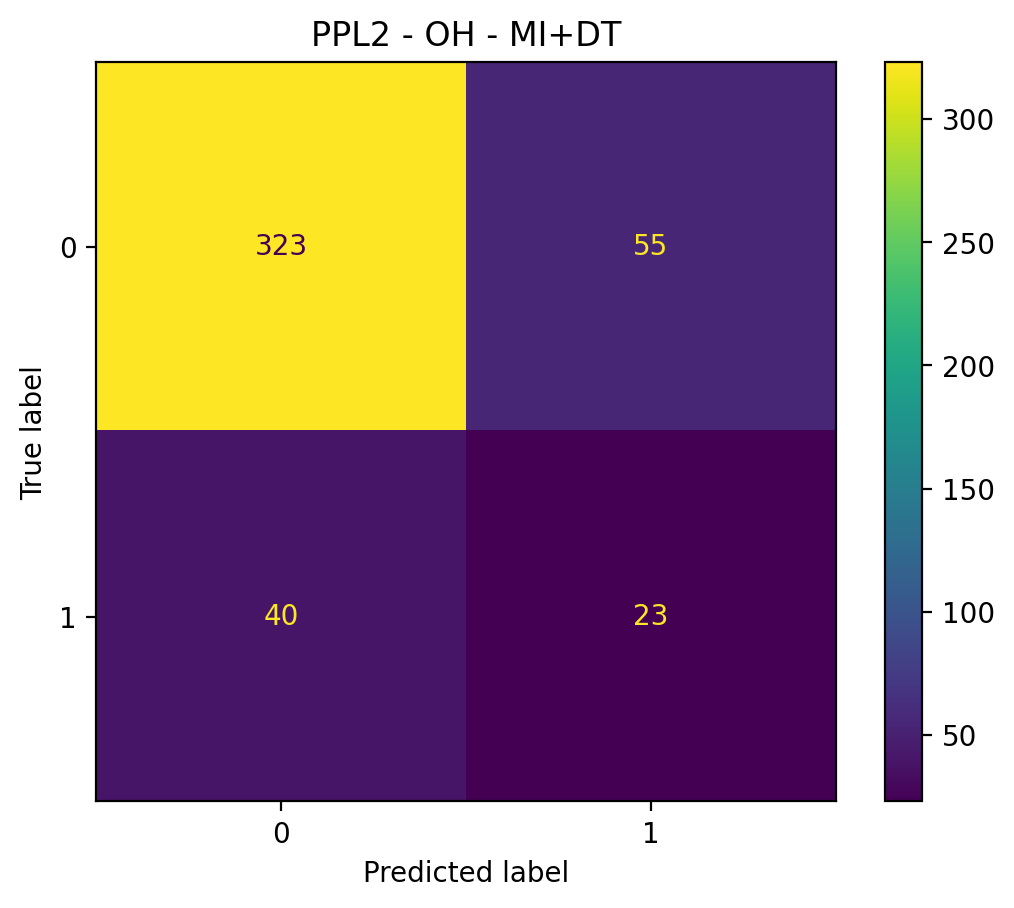

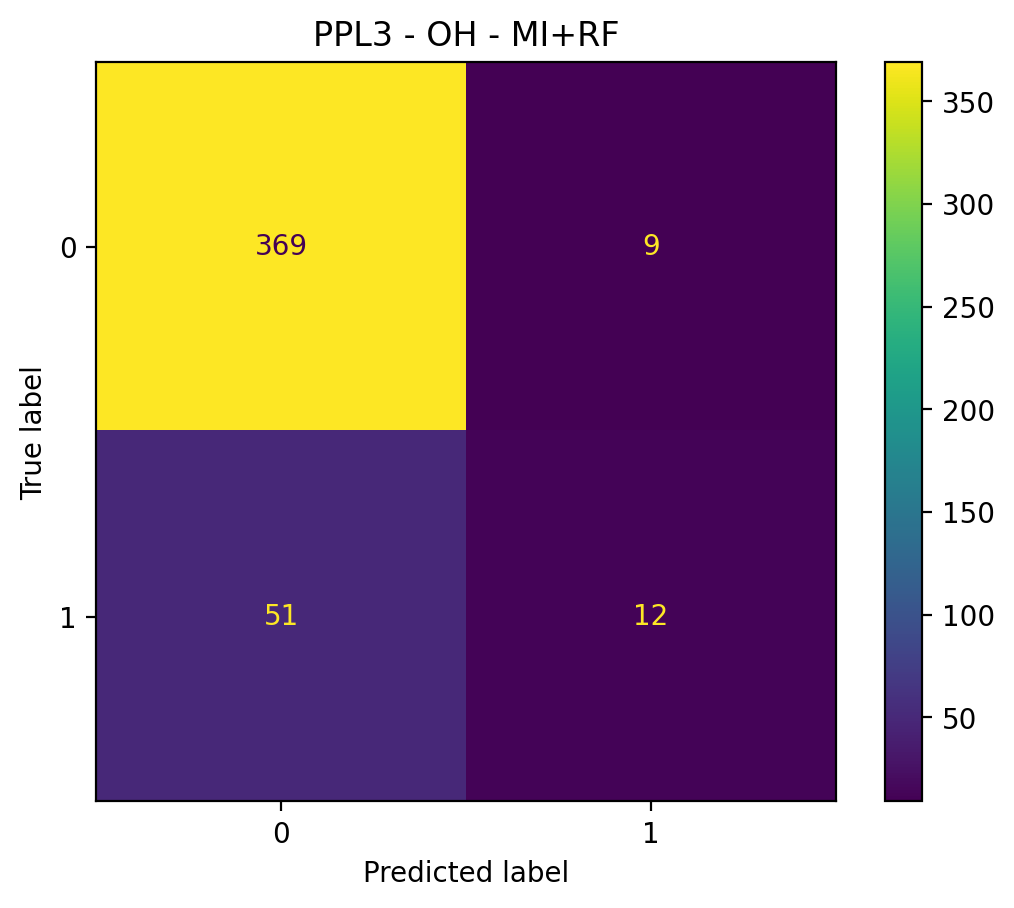

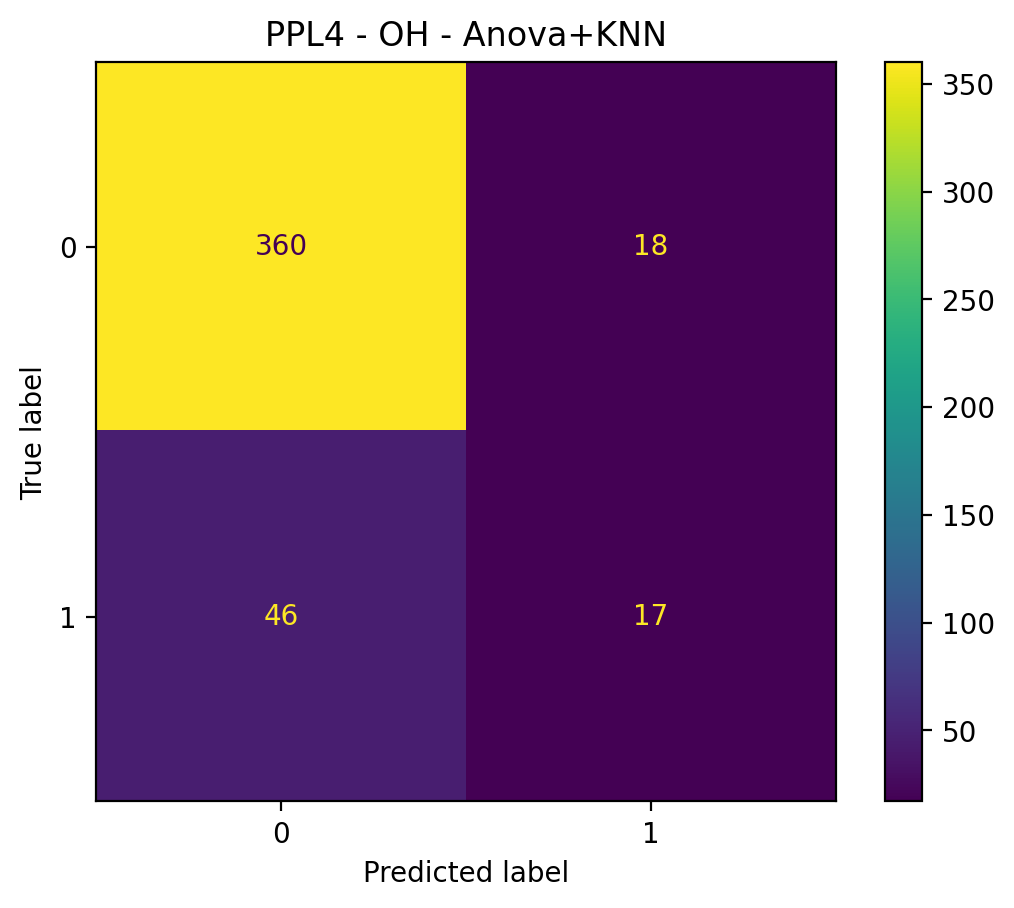

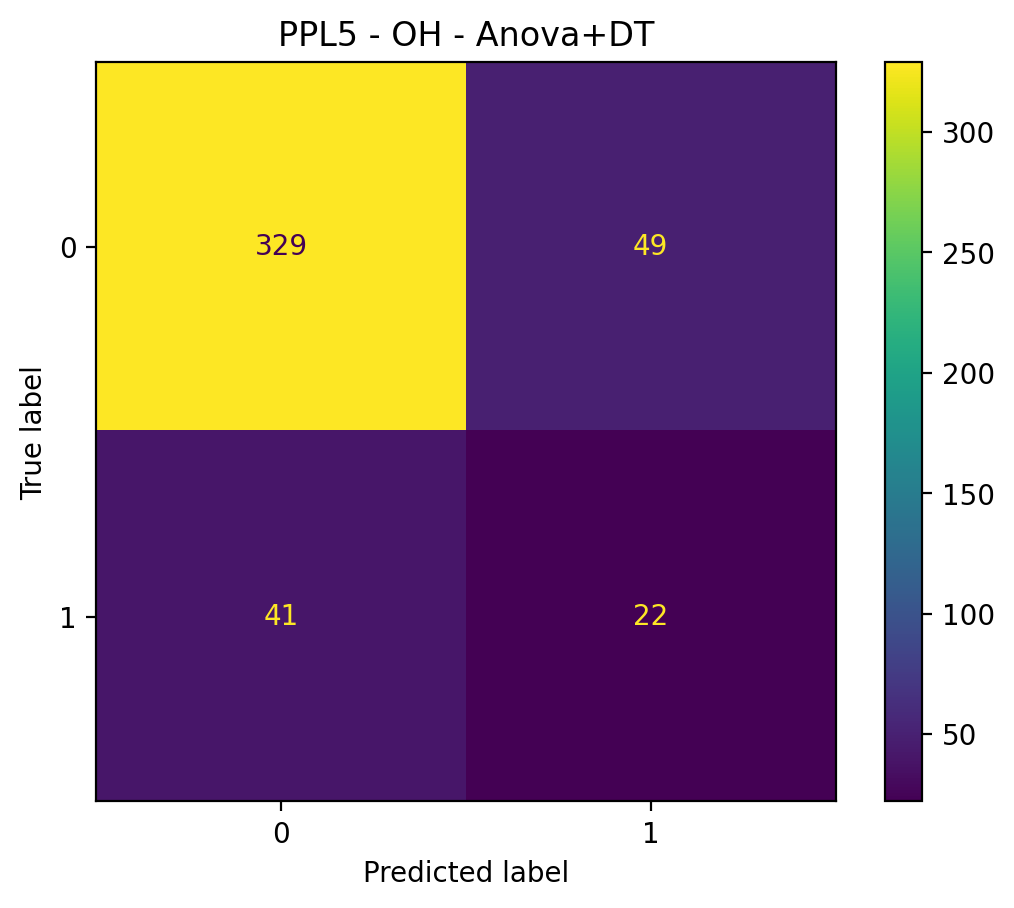

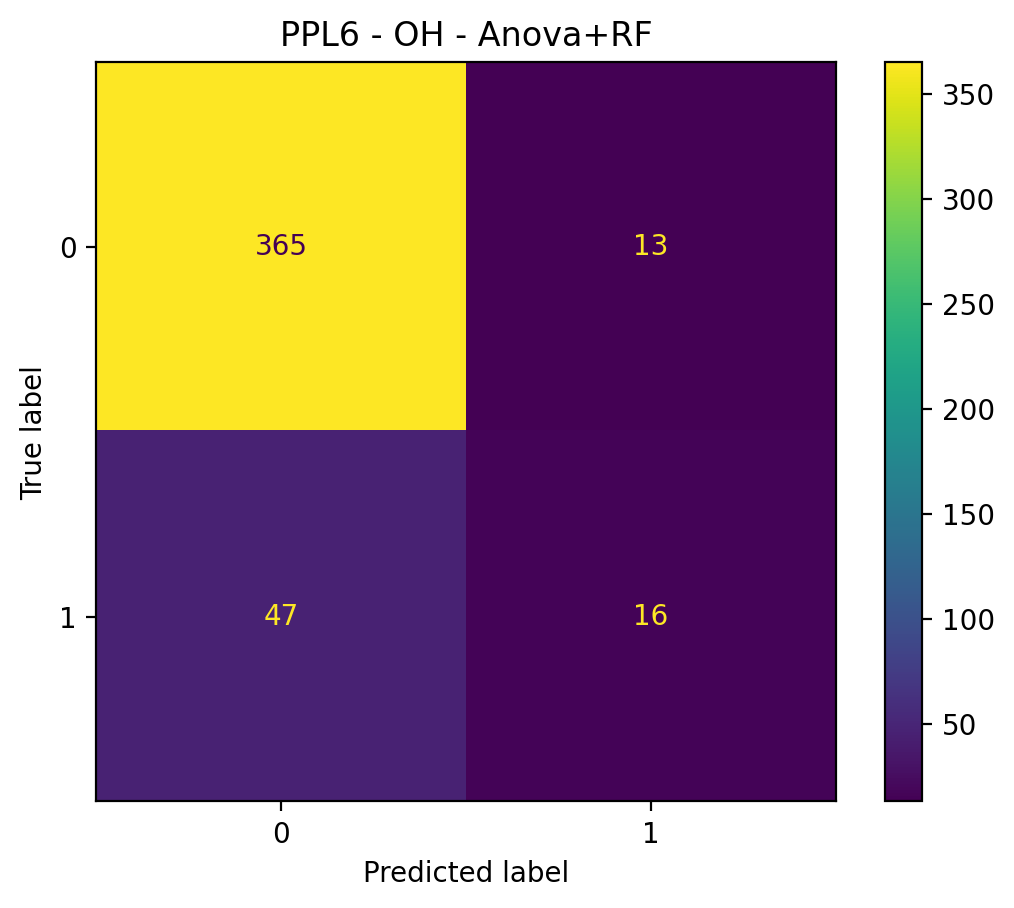

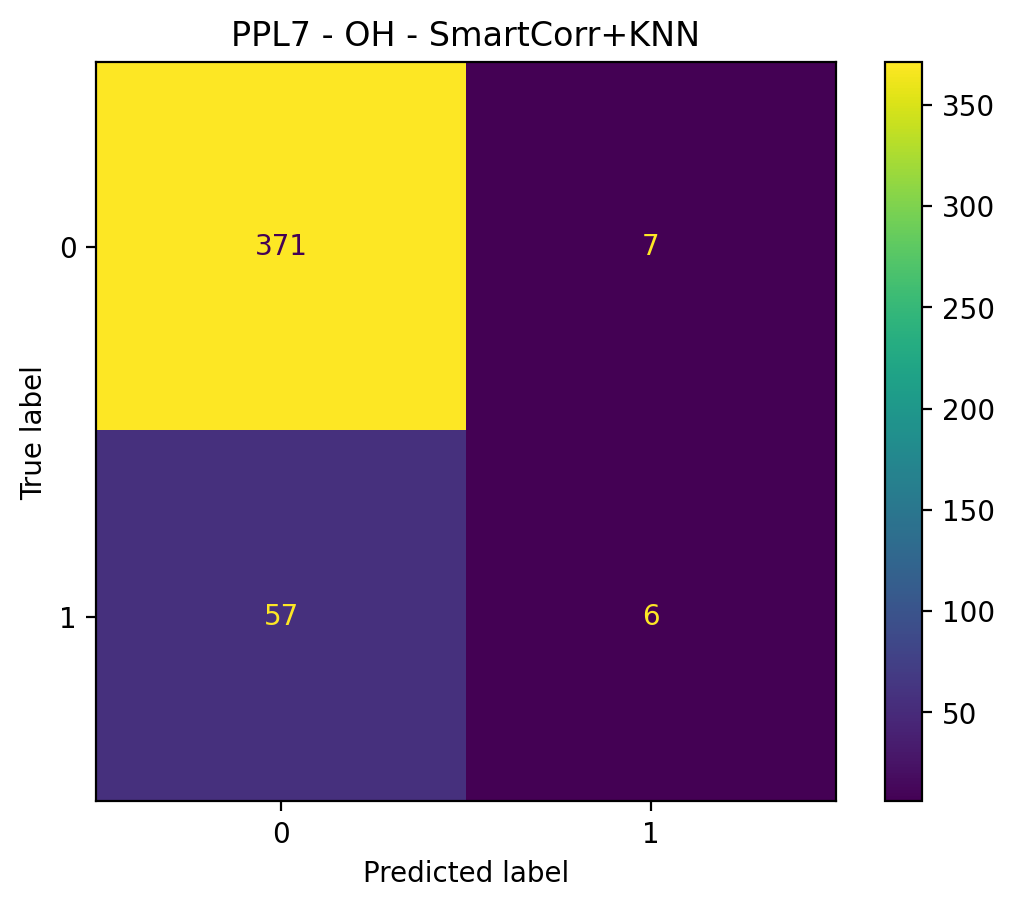

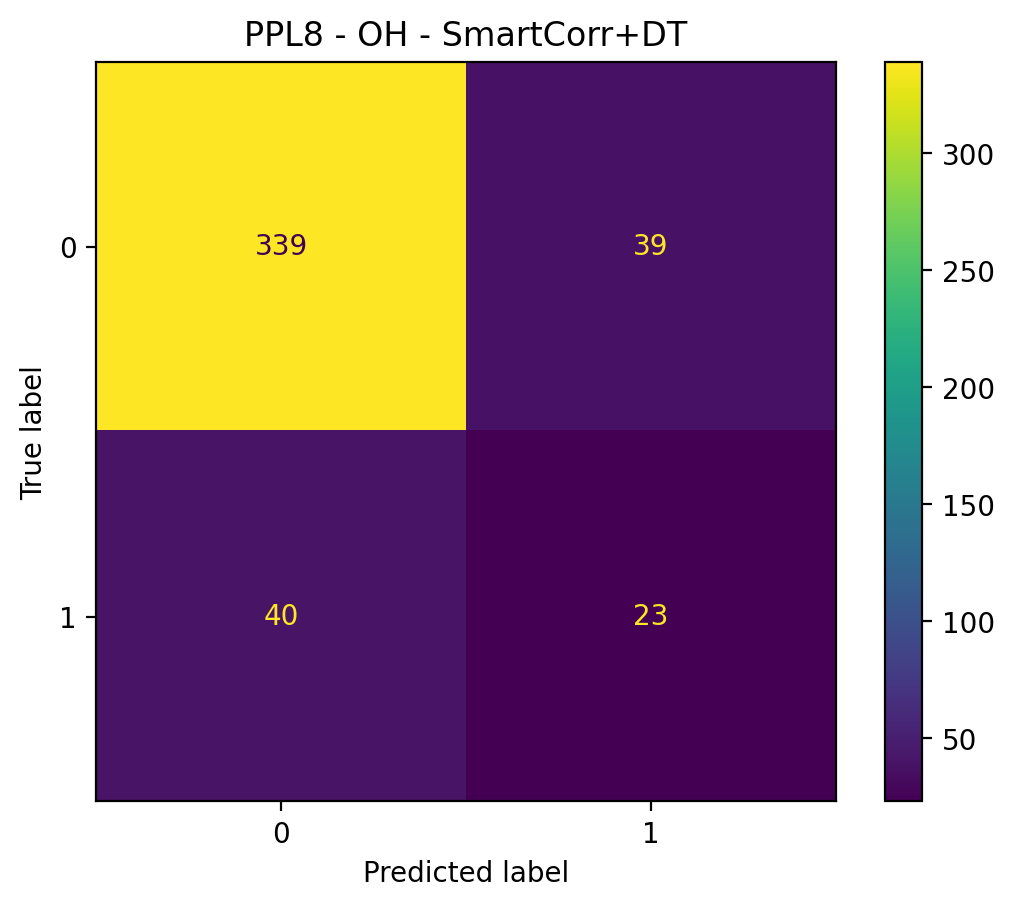

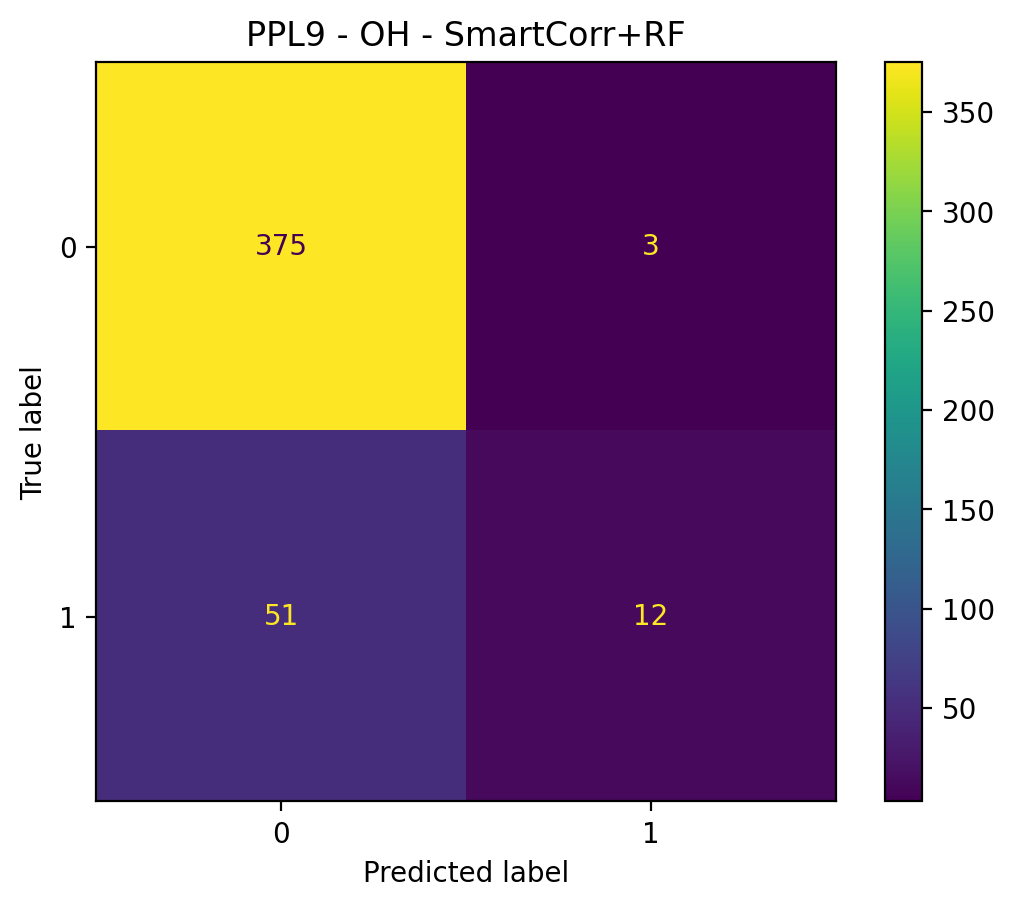

In [30]:
dct_pred = {
    'PPL1 - LE - MI+KNN': ppl1LE_pred,
    'PPL2 - LE - MI+DT': ppl2LE_pred,
    'PPL3 - LE - MI+RF': ppl3LE_pred,
    'PPL4 - LE - Anova+KNN': ppl4LE_pred,
    'PPL5 - LE - Anova+DT': ppl5LE_pred,
    'PPL6 - LE - Anova+RF': ppl6LE_pred,
    'PPL7 - LE - SmartCorr+KNN': ppl7LE_pred,
    'PPL8 - LE - SmartCorr+DT': ppl8LE_pred,
    'PPL9 - LE - SmartCorr+RF': ppl9LE_pred,
    'PPL1 - OH - MI+KNN': ppl1OH_pred,
    'PPL2 - OH - MI+DT': ppl2OH_pred,
    'PPL3 - OH - MI+RF': ppl3OH_pred,
    'PPL4 - OH - Anova+KNN': ppl4OH_pred,
    'PPL5 - OH - Anova+DT': ppl5OH_pred,
    'PPL6 - OH - Anova+RF': ppl6OH_pred,
    'PPL7 - OH - SmartCorr+KNN': ppl7OH_pred,
    'PPL8 - OH - SmartCorr+DT': ppl8OH_pred,
    'PPL9 - OH - SmartCorr+RF': ppl9OH_pred
}


for pipe in dct_pred:
    if pipe[7:9] == 'LE':
        y_eval = y_testLE
    elif pipe[7:9] == 'OH':
        y_eval = y_testOH
    cm = confusion_matrix(y_eval, dct_pred[pipe])
    ConfusionMatrixDisplay(cm).plot()
    plt.title(pipe)
    plt.show()
    

In [31]:
print(" -=-=-=-=-=-= Label Encoder =-=-=-=-=-=- ")
print(f"Pipelines com KNN")
print(f"{' ':^10s} | {'ACC':^10s} | {'Recall':^10s} | {'Precision':^10s} | {'F1-Score':^10s}")
print(f"{'Completo':<10s} | {accuracy_score(y_testLE,knnLE_pred):10.4f} | {recall_score(y_testLE,knnLE_pred):10.4f} | {precision_score(y_testLE,knnLE_pred):10.4f} | {f1_score(y_testLE,knnLE_pred):10.4f}")
print(f"{'MI':<10s} | {accuracy_score(y_testLE,ppl1LE_pred):10.4f} | {recall_score(y_testLE,ppl1LE_pred):10.4f} | {precision_score(y_testLE,ppl1LE_pred):10.4f} | {f1_score(y_testLE,ppl1LE_pred):10.4f}")
print(f"{'Anova':<10s} | {accuracy_score(y_testLE,ppl4LE_pred):10.4f} | {recall_score(y_testLE,ppl4LE_pred):10.4f} | {precision_score(y_testLE,ppl4LE_pred):10.4f} | {f1_score(y_testLE,ppl4LE_pred):10.4f}")
print(f"{'SmartC':<10s} | {accuracy_score(y_testLE,ppl7LE_pred):10.4f} | {recall_score(y_testLE,ppl7LE_pred):10.4f} | {precision_score(y_testLE,ppl7LE_pred):10.4f} | {f1_score(y_testLE,ppl7LE_pred):10.4f}")
print('-=-'*21)
print(f"Pipelines com Decision Tree")
print(f"{' ':^10s} | {'ACC':^10s} | {'Recall':^10s} | {'Precision':^10s} | {'F1-Score':^10s}")
print(f"{'Completo':<10s} | {accuracy_score(y_testLE,treeLE_pred):10.4f} | {recall_score(y_testLE,treeLE_pred):10.4f} | {precision_score(y_testLE,treeLE_pred):10.4f} | {f1_score(y_testLE,treeLE_pred):10.4f}")
print(f"{'MI':<10s} | {accuracy_score(y_testLE,ppl2LE_pred):10.4f} | {recall_score(y_testLE,ppl2LE_pred):10.4f} | {precision_score(y_testLE,ppl2LE_pred):10.4f} | {f1_score(y_testLE,ppl2LE_pred):10.4f}")
print(f"{'Anova':<10s} | {accuracy_score(y_testLE,ppl5LE_pred):10.4f} | {recall_score(y_testLE,ppl5LE_pred):10.4f} | {precision_score(y_testLE,ppl5LE_pred):10.4f} | {f1_score(y_testLE,ppl5LE_pred):10.4f}")
print(f"{'SmartC':<10s} | {accuracy_score(y_testLE,ppl8LE_pred):10.4f} | {recall_score(y_testLE,ppl8LE_pred):10.4f} | {precision_score(y_testLE,ppl8LE_pred):10.4f} | {f1_score(y_testLE,ppl8LE_pred):10.4f}")
print('-=-'*21)
print(f"Pipelines com Random Forest")
print(f"{' ':^10s} | {'ACC':^10s} | {'Recall':^10s} | {'Precision':^10s} | {'F1-Score':^10s}")
print(f"{'Completo':<10s} | {accuracy_score(y_testLE,forestLE_pred):10.4f} | {recall_score(y_testLE,forestLE_pred):10.4f} | {precision_score(y_testLE,forestLE_pred):10.4f} | {f1_score(y_testLE,forestLE_pred):10.4f}")
print(f"{'MI':<10s} | {accuracy_score(y_testLE,ppl3LE_pred):10.4f} | {recall_score(y_testLE,ppl3LE_pred):10.4f} | {precision_score(y_testLE,ppl3LE_pred):10.4f} | {f1_score(y_testLE,ppl3LE_pred):10.4f}")
print(f"{'Anova':<10s} | {accuracy_score(y_testLE,ppl6LE_pred):10.4f} | {recall_score(y_testLE,ppl6LE_pred):10.4f} | {precision_score(y_testLE,ppl6LE_pred):10.4f} | {f1_score(y_testLE,ppl6LE_pred):10.4f}")
print(f"{'SmartC':<10s} | {accuracy_score(y_testLE,ppl9LE_pred):10.4f} | {recall_score(y_testLE,ppl9LE_pred):10.4f} | {precision_score(y_testLE,ppl9LE_pred):10.4f} | {f1_score(y_testLE,ppl9LE_pred):10.4f}")
print('-=-'*21)


 -=-=-=-=-=-= Label Encoder =-=-=-=-=-=- 
Pipelines com KNN
           |    ACC     |   Recall   | Precision  |  F1-Score 
Completo   |     0.8481 |     0.1127 |     0.6667 |     0.1928
MI         |     0.8458 |     0.1408 |     0.5882 |     0.2273
Anova      |     0.8435 |     0.0704 |     0.6250 |     0.1266
SmartC     |     0.8481 |     0.1127 |     0.6667 |     0.1928
-=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=-
Pipelines com Decision Tree
           |    ACC     |   Recall   | Precision  |  F1-Score 
Completo   |     0.8027 |     0.5352 |     0.4130 |     0.4663
MI         |     0.7710 |     0.4507 |     0.3404 |     0.3879
Anova      |     0.8073 |     0.4789 |     0.4146 |     0.4444
SmartC     |     0.7959 |     0.3662 |     0.3662 |     0.3662
-=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=-
Pipelines com Random Forest
           |    ACC     |   Recall   | Precision  |  F1-Score 
Completo   |     0.8549 |     0.1408 |     0.7692 |     0.2381


In [32]:
print(" -=-=-=-=-=-= One Hot Encoder =-=-=-=-=-=- ")
print(f"Pipelines com KNN")
print(f"{' ':^10s} | {'ACC':^10s} | {'Recall':^10s} | {'Precision':^10s} | {'F1-Score':^10s}")
print(f"{'Completo':<10s} | {accuracy_score(y_testOH,knnOH_pred):10.4f} | {recall_score(y_testOH,knnOH_pred):10.4f} | {precision_score(y_testOH,knnOH_pred):10.4f} | {f1_score(y_testOH,knnOH_pred):10.4f}")
print(f"{'MI':<10s} | {accuracy_score(y_testOH,ppl1OH_pred):10.4f} | {recall_score(y_testOH,ppl1OH_pred):10.4f} | {precision_score(y_testOH,ppl1OH_pred):10.4f} | {f1_score(y_testOH,ppl1OH_pred):10.4f}")
print(f"{'Anova':<10s} | {accuracy_score(y_testOH,ppl4OH_pred):10.4f} | {recall_score(y_testOH,ppl4OH_pred):10.4f} | {precision_score(y_testOH,ppl4OH_pred):10.4f} | {f1_score(y_testOH,ppl4OH_pred):10.4f}")
print(f"{'SmartC':<10s} | {accuracy_score(y_testOH,ppl7OH_pred):10.4f} | {recall_score(y_testOH,ppl7OH_pred):10.4f} | {precision_score(y_testOH,ppl7OH_pred):10.4f} | {f1_score(y_testOH,ppl7OH_pred):10.4f}")
print('-=-'*21)
print(f"Pipelines com Decision Tree")
print(f"{' ':^10s} | {'ACC':^10s} | {'Recall':^10s} | {'Precision':^10s} | {'F1-Score':^10s}")
print(f"{'Completo':<10s} | {accuracy_score(y_testOH,treeOH_pred):10.4f} | {recall_score(y_testOH,treeOH_pred):10.4f} | {precision_score(y_testOH,treeOH_pred):10.4f} | {f1_score(y_testOH,treeOH_pred):10.4f}")
print(f"{'MI':<10s} | {accuracy_score(y_testOH,ppl2OH_pred):10.4f} | {recall_score(y_testOH,ppl2OH_pred):10.4f} | {precision_score(y_testOH,ppl2OH_pred):10.4f} | {f1_score(y_testOH,ppl2OH_pred):10.4f}")
print(f"{'Anova':<10s} | {accuracy_score(y_testOH,ppl5OH_pred):10.4f} | {recall_score(y_testOH,ppl5OH_pred):10.4f} | {precision_score(y_testOH,ppl5OH_pred):10.4f} | {f1_score(y_testOH,ppl5OH_pred):10.4f}")
print(f"{'SmartC':<10s} | {accuracy_score(y_testOH,ppl8OH_pred):10.4f} | {recall_score(y_testOH,ppl8OH_pred):10.4f} | {precision_score(y_testOH,ppl8OH_pred):10.4f} | {f1_score(y_testOH,ppl8OH_pred):10.4f}")
print('-=-'*21)
print(f"Pipelines com Random Forest")
print(f"{' ':^10s} | {'ACC':^10s} | {'Recall':^10s} | {'Precision':^10s} | {'F1-Score':^10s}")
print(f"{'Completo':<10s} | {accuracy_score(y_testOH,forestOH_pred):10.4f} | {recall_score(y_testOH,forestOH_pred):10.4f} | {precision_score(y_testOH,forestOH_pred):10.4f} | {f1_score(y_testOH,forestOH_pred):10.4f}")
print(f"{'MI':<10s} | {accuracy_score(y_testOH,ppl3OH_pred):10.4f} | {recall_score(y_testOH,ppl3OH_pred):10.4f} | {precision_score(y_testOH,ppl3OH_pred):10.4f} | {f1_score(y_testOH,ppl3OH_pred):10.4f}")
print(f"{'Anova':<10s} | {accuracy_score(y_testOH,ppl6OH_pred):10.4f} | {recall_score(y_testOH,ppl6OH_pred):10.4f} | {precision_score(y_testOH,ppl6OH_pred):10.4f} | {f1_score(y_testOH,ppl6OH_pred):10.4f}")
print(f"{'SmartC':<10s} | {accuracy_score(y_testOH,ppl9OH_pred):10.4f} | {recall_score(y_testOH,ppl9OH_pred):10.4f} | {precision_score(y_testOH,ppl9OH_pred):10.4f} | {f1_score(y_testOH,ppl9OH_pred):10.4f}")
print('-=-'*21)

 -=-=-=-=-=-= One Hot Encoder =-=-=-=-=-=- 
Pipelines com KNN
           |    ACC     |   Recall   | Precision  |  F1-Score 
Completo   |     0.8549 |     0.0952 |     0.4615 |     0.1579
MI         |     0.8435 |     0.1429 |     0.3750 |     0.2069
Anova      |     0.8549 |     0.2698 |     0.4857 |     0.3469
SmartC     |     0.8549 |     0.0952 |     0.4615 |     0.1579
-=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=-
Pipelines com Decision Tree
           |    ACC     |   Recall   | Precision  |  F1-Score 
Completo   |     0.7982 |     0.3175 |     0.3030 |     0.3101
MI         |     0.7846 |     0.3651 |     0.2949 |     0.3262
Anova      |     0.7959 |     0.3492 |     0.3099 |     0.3284
SmartC     |     0.8209 |     0.3651 |     0.3710 |     0.3680
-=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=-
Pipelines com Random Forest
           |    ACC     |   Recall   | Precision  |  F1-Score 
Completo   |     0.8776 |     0.2063 |     0.7647 |     0.325

Percebe-se que os melhores desempenhos foram utilizando os dados com LabelEncoder + Decision Tree. Portanto, a partir de agora, seguiremos com eles, e buscaremos outras técnicas. 


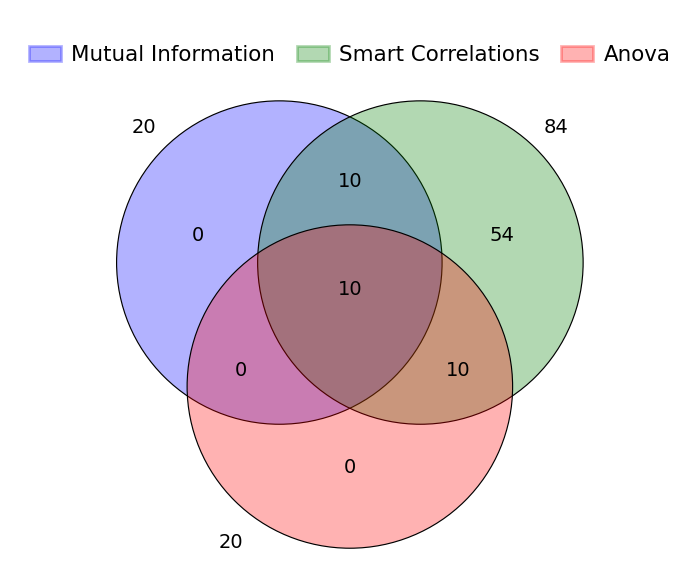

In [33]:
featuresDecTreeMI = ppl2LE[:-1].get_feature_names_out()
featuresDecTreeAnova = ppl5LE[:-1].get_feature_names_out()
featuresDecTreeSmartC = ppl8LE[:-1].get_feature_names_out()

sets = {
    'Mutual Information': set(featuresDecTreeMI),
    'Smart Correlations': set(featuresDecTreeSmartC),
    'Anova': set(featuresDecTreeAnova)
}

venny4py(sets=sets)

Pelo incremento nas méticas vs aumento da complexidade, seguirei com Anova e Mutual Information como técnicas de seleção de atributo (`ppl2LE` e `ppl5LE`)

### Testando com balanceamento de classes

In [34]:
df['Attrition'].value_counts()

Attrition
No     1233
Yes     237
Name: count, dtype: int64

In [35]:
sm = SMOTE()
X_train_oversampled, y_train_oversampled = sm.fit_resample(X_trainLE, y_trainLE)

In [46]:
y_trainLE.value_counts()

Attrition
0    863
1    166
Name: count, dtype: int64

In [47]:
y_train_oversampled.value_counts()

Attrition
0    863
1    863
Name: count, dtype: int64

In [48]:
newppl2 = Pipeline([('mi_s', mi), ('dt_c', treeLE)])
newppl2.fit(X_train_oversampled, y_train_oversampled )
newppl2_pred = newppl2.predict(X_testLE)

newppl5 = Pipeline([('anova_s', anova), ('dt_c', treeLE)])
newppl5.fit(X_train_oversampled, y_train_oversampled )
newppl5_pred = newppl5.predict(X_testLE)


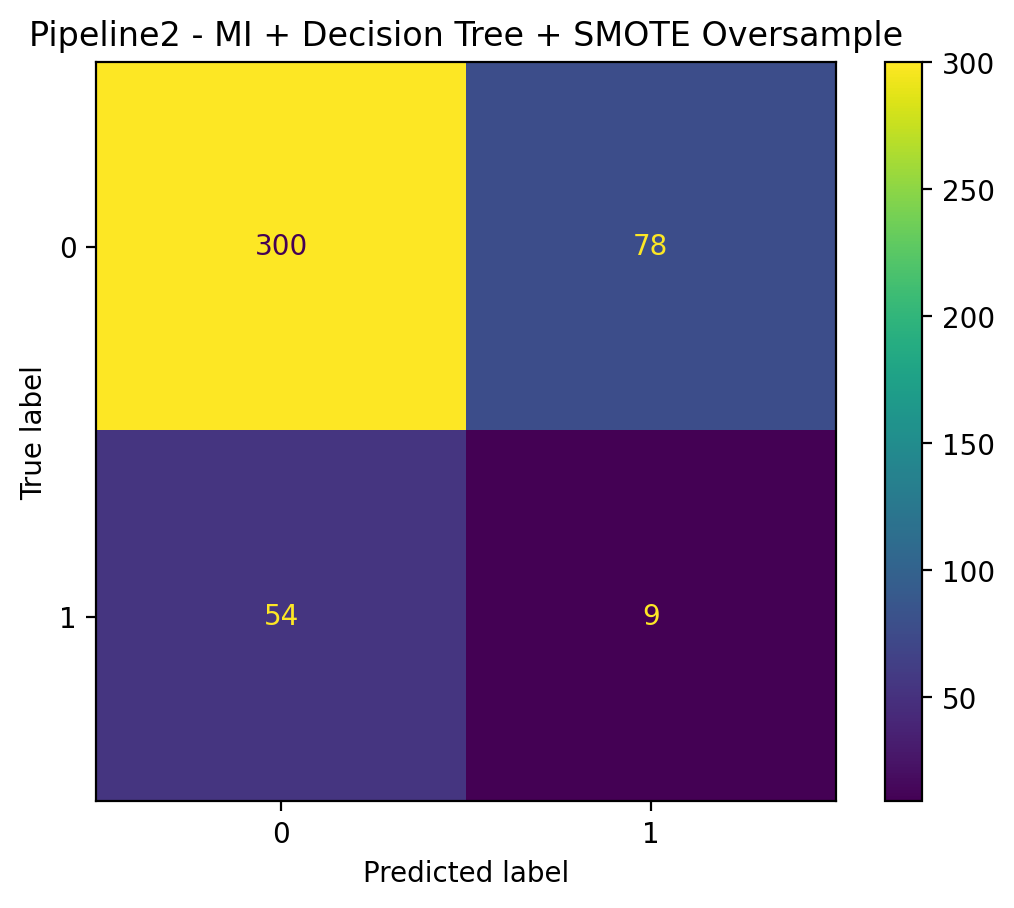

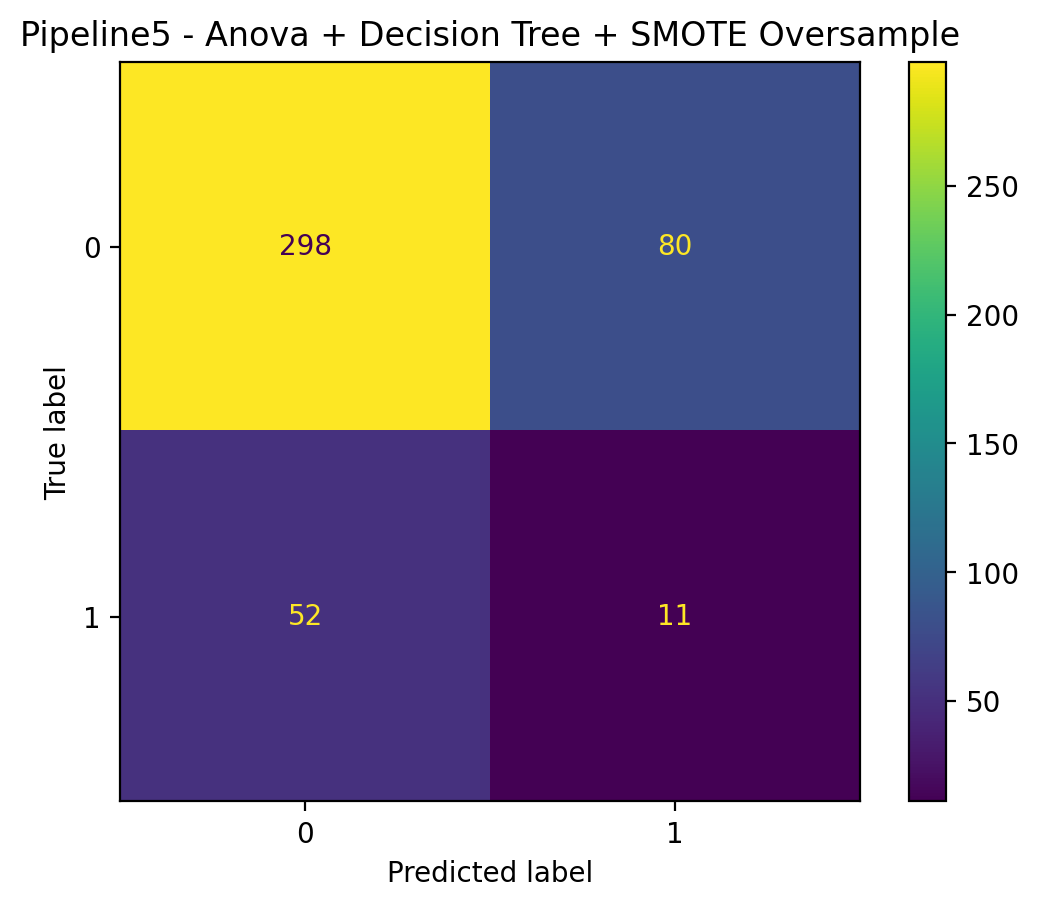

In [49]:
cm = confusion_matrix(y_eval, newppl2_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title('Pipeline2 - MI + Decision Tree + SMOTE Oversample')
plt.show()

cm = confusion_matrix(y_eval, newppl5_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title('Pipeline5 - Anova + Decision Tree + SMOTE Oversample')
plt.show()

In [50]:
print(f"{' ':^10s} | {'ACC':^10s} | {'Recall':^10s} | {'Precision':^10s} | {'F1-Score':^10s}")
print(f"{'MI':<10s} | {accuracy_score(y_testLE,newppl2_pred):10.4f} | {recall_score(y_testLE,newppl2_pred):10.4f} | {precision_score(y_testLE,newppl2_pred):10.4f} | {f1_score(y_testLE,newppl2_pred):10.4f}")
print(f"{'Anova':<10s} | {accuracy_score(y_testLE,newppl5_pred):10.4f} | {recall_score(y_testLE,newppl5_pred):10.4f} | {precision_score(y_testLE,newppl5_pred):10.4f} | {f1_score(y_testLE,newppl5_pred):10.4f}")

           |    ACC     |   Recall   | Precision  |  F1-Score 
MI         |     0.7506 |     0.3380 |     0.2759 |     0.3038
Anova      |     0.7415 |     0.3380 |     0.2637 |     0.2963


In [52]:
print('Pipeline2 - MI + Decision Tree + SMOTE Oversample')
print(classification_report(y_testLE,ppl2LE_pred))
print('Pipeline5 - Anova + Decision Tree + SMOTE Oversample')
print(classification_report(y_testLE,ppl5LE_pred))

Pipeline2 - MI + Decision Tree + SMOTE Oversample
              precision    recall  f1-score   support

           0       0.89      0.83      0.86       370
           1       0.34      0.45      0.39        71

    accuracy                           0.77       441
   macro avg       0.61      0.64      0.62       441
weighted avg       0.80      0.77      0.78       441

Pipeline5 - Anova + Decision Tree + SMOTE Oversample
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       370
           1       0.41      0.48      0.44        71

    accuracy                           0.81       441
   macro avg       0.66      0.67      0.66       441
weighted avg       0.82      0.81      0.81       441



In [51]:
print('Pipeline2 - MI + Decision Tree + SMOTE Oversample')
print(classification_report(y_testLE,newppl2_pred))
print('Pipeline5 - Anova + Decision Tree + SMOTE Oversample')
print(classification_report(y_testLE,newppl5_pred))

Pipeline2 - MI + Decision Tree + SMOTE Oversample
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       370
           1       0.28      0.34      0.30        71

    accuracy                           0.75       441
   macro avg       0.57      0.58      0.58       441
weighted avg       0.77      0.75      0.76       441

Pipeline5 - Anova + Decision Tree + SMOTE Oversample
              precision    recall  f1-score   support

           0       0.87      0.82      0.84       370
           1       0.26      0.34      0.30        71

    accuracy                           0.74       441
   macro avg       0.56      0.58      0.57       441
weighted avg       0.77      0.74      0.75       441



Podese afirmar que neste caso, o balanceamento das classes não foi eficiente, uma vez que todas as métricas caíram com relação aos pipelines originais. 

### Testando com Cross Validation + Busca de hiperparâmetros

In [57]:
skf = StratifiedKFold(n_splits=10, shuffle=True)
param_grid = {'criterion': ['gini', 'entropy', 'log_loss'],
              'splitter': ['best', 'random'],
              'max_features': ['sqrt','log2', None]}

In [60]:
g_search = GridSearchCV(estimator = treeLE,
                        param_grid = param_grid,
                        refit=True,
                        cv = skf,
                        return_train_score=True)

In [64]:
g_search.fit(X_trainLE, y_trainLE)
y_predSearch = g_search.predict(X_testLE)


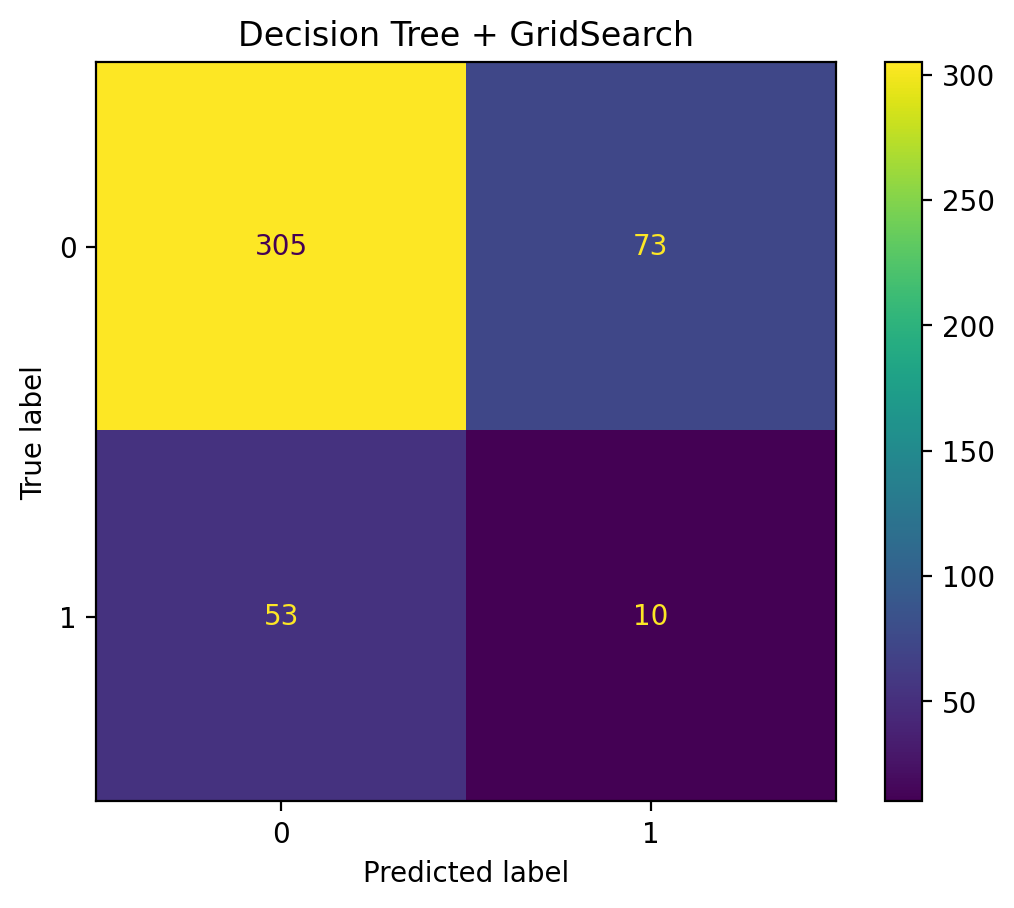

In [66]:
cm = confusion_matrix(y_eval, y_predSearch)
ConfusionMatrixDisplay(cm).plot()
plt.title('Decision Tree + GridSearch')
plt.show()

In [67]:
print(classification_report(y_testLE,y_predSearch))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87       370
           1       0.36      0.42      0.39        71

    accuracy                           0.79       441
   macro avg       0.62      0.64      0.63       441
weighted avg       0.80      0.79      0.79       441



Todas as técnicas utilizadas apresentaram muito pouca variação nas métricas de avaliação, indicando que uma busca maior por melhores parâmetros tem um potencial igual à aplicação de diversas técnicas sobre a base de dados. 